# Instructions :
Travail en groupe, à  placer dans le premier dépot Git de notre année Universitaire, dans le dossier <code>Computer Vision</code>.


# Membres du Groupe :

1. Fiatoa Tovomanandrafale ESIIA 4 n°:26
2. ANDRIAMANARINTSOA Fenohasina Zianah ESIIA 4 n°02
3. ANDRIAMANANTSOA Tiavina Rollando IGGLIA 4 n°08
4. RANDRIANJAFIENIARIVO Tojo Fandresena IGGLIA 4 n°27
5. RAKOTOMANGA Harijaona IGGLIA 4 n°43


# Autoencodeurs pour Images de Cercles

Dans ce notebook, nous allons générer un dataset synthétique où chaque image est une image en niveaux de gris de taille 64x64 contenant un cercle blanc (de centre et rayon aléatoires) sur fond noir. Le but est d'entraîner des autoencodeurs qui réduisent ces images dans un espace latent de dimension 3, puis les reconstruisent.

Nous étudierons deux configurations :
- Un autoencodeur entièrement connecté
- Un autoencodeur convolutionnel

Vous pourrez comparer leurs performances et discuter des compromis liés à la conception de l'espace latent.

## Étape 1 : Génération du Dataset

Nous allons générer un dataset d'images où chaque image comporte un cercle blanc de centre et de rayon aléatoires. Pour cela, nous utiliserons la bibliothèque OpenCV pour dessiner le cercle sur une image noire.

### Explication Pratique
La génération d'un dataset synthétique permet de contrôler précisément les paramètres (ici, le centre et le rayon du cercle) et de disposer d'une base simple pour expérimenter la réduction dimensionnelle via l'espace latent.

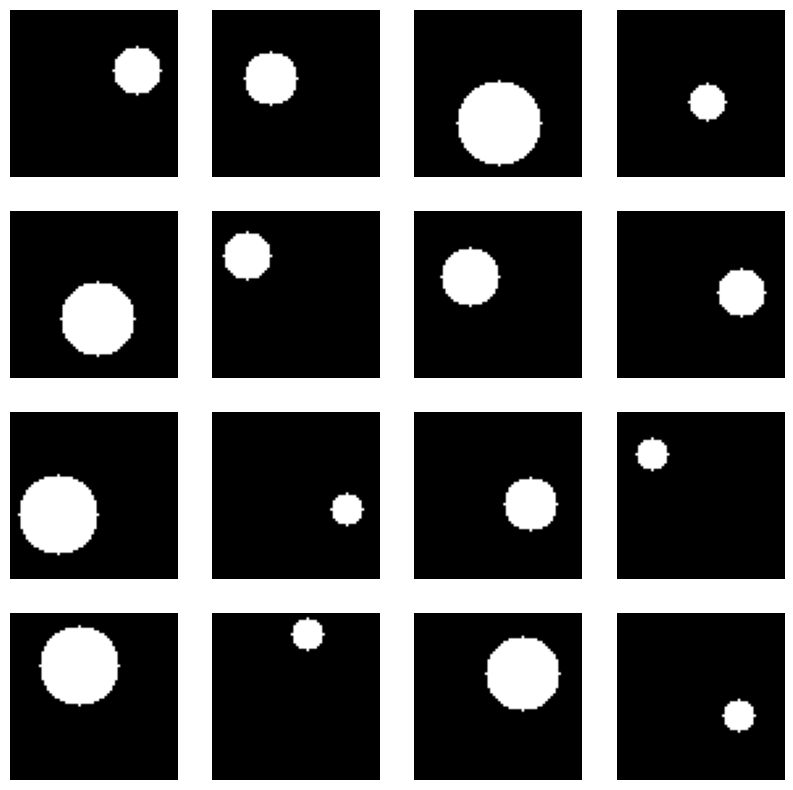

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_circle_image(image_size=64, min_radius=5, max_radius=20):
    """Génère une image en niveaux de gris de taille image_size x image_size contenant un cercle blanc."""
    # Créer une image noire
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    # Choisir un rayon aléatoire
    radius = np.random.randint(min_radius, max_radius)

    # Choisir un centre aléatoire de sorte que le cercle soit entièrement contenu dans l'image
    x = np.random.randint(radius, image_size - radius)
    y = np.random.randint(radius, image_size - radius)

    # Dessiner le cercle (couleur blanche: 255, épaisseur=-1 pour un remplissage complet)
    cv2.circle(image, (x, y), radius, 255, -1)

    # Normaliser l'image entre 0 et 1
    image = image.astype('float32') / 255.0

    return image

def generate_dataset(n_samples=10000, image_size=64):
    data = []
    for _ in range(n_samples):
        img = generate_circle_image(image_size=image_size)
        data.append(img)
    data = np.array(data)
    # Ajouter une dimension pour le canal (images en niveaux de gris)
    data = np.expand_dims(data, axis=-1)
    return data

# Générer le dataset
data = generate_dataset(n_samples=10000, image_size=64)

# Afficher quelques exemples
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(data[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


## Étape 2 : Préparation des Données

Nous allons diviser le dataset en ensembles d'entraînement et de test. Ici, nous utilisons 80 % des données pour l'entraînement et 20 % pour le test.

In [5]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print('Entraînement:', train_data.shape)
print('Test:', test_data.shape)


Entraînement: (8000, 64, 64, 1)
Test: (2000, 64, 64, 1)


## Étape 3 : Autoencodeur Entièrement Connecté (Dense Layers)

Dans cette partie, nous construisons un autoencodeur entièrement connecté. Le modèle comporte :

- **Encodeur :** Un aplatissement de l'image suivi d'une couche Dense de 128 neurones (activation ReLU) puis une couche Dense de 3 neurones qui représente l'espace latent.
- **Décodeur :** Une couche Dense de 128 neurones (activation ReLU), suivie d'une couche Dense de 4096 neurones (pour reconstruire une image 64x64) avec activation sigmoïde, puis un reshape en (64,64,1).

### Explication Pratique
Cet autoencodeur simple permet de voir comment les informations (ici, la position et la taille du cercle) sont comprimées dans un espace de très faible dimension.

In [6]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(64, 64, 1))
x = layers.Flatten()(input_img)
x = layers.Dense(128, activation='relu')(x)
latent = layers.Dense(3, name='latent_space')(x)  # Espace latent de dimension 3

x = layers.Dense(128, activation='relu')(latent)
x = layers.Dense(64*64, activation='sigmoid')(x)
decoded = layers.Reshape((64, 64, 1))(x)

autoencoder_fc = models.Model(input_img, decoded)

autoencoder_fc.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_fc.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │             387 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 64, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,053,699 (4.02 MB)

 Trainable params: 1,053,699 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Entièrement Connecté FCN (Dense layers)

Nous allons entraîner cet autoencodeur sur l'ensemble d'entraînement.

In [16]:
history_fc = autoencoder_fc.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))

# Sauvegarder le modèle après l'entraînement
autoencoder_fc.save('autoencoder_fc.keras')  # Pour l'autoencodeur entièrement connecté

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0104 - val_loss: 0.0153
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0104 - val_loss: 0.0155
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0150
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - val_loss: 0.0154
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - val_loss: 0.0152
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - val_loss: 0.0149
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097 - val_loss: 0.0151
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0155
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099 - val_loss: 0.0153
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0098 - val_loss: 0.0157
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0101 - val_loss: 0.0153
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_lo

### Visualisation des Reconstructions (FC)

Affichons quelques reconstructions pour évaluer qualitativement les performances de l'autoencodeur entièrement connecté.

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


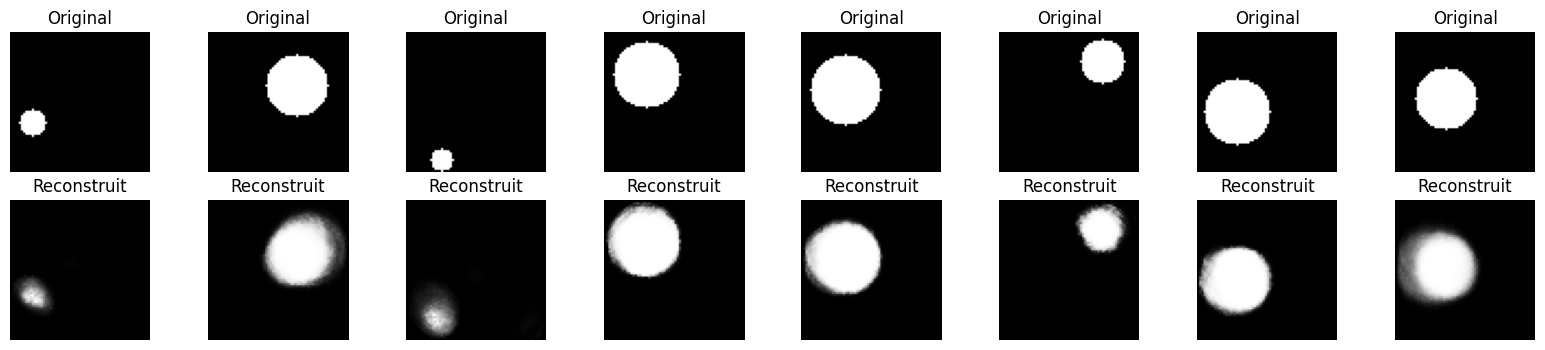

In [8]:
decoded_imgs_fc = autoencoder_fc.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Étape 4 : Autoencodeur Convolutionnel

Nous allons maintenant construire un autoencodeur convolutionnel. Cette architecture est généralement mieux adaptée pour traiter des images car elle exploite la structure spatiale.

### Architecture
- **Encodeur :**
  - Conv2D(32, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Conv2D(64, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Flatten puis Dense(3) pour obtenir le latent space
- **Décodeur :**
  - Dense(16*16*64, activation='relu') puis Reshape en (16,16,64)
  - Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')
  - Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')
  - Conv2D(1, 3, activation='sigmoid', padding='same') pour reconstruire l'image

### Explication Pratique
Les autoencodeurs convolutionnels capturent mieux la structure locale des images, ce qui peut améliorer la qualité des reconstructions par rapport à une architecture entièrement connectée.

In [9]:
input_img = layers.Input(shape=(64, 64, 1))

# Encodeur
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Flatten()(x)
latent = layers.Dense(3, name='latent_space')(x)

# Décodeur
x = layers.Dense(16*16*64, activation='relu')(latent)
x = layers.Reshape((16,16,64))(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder_conv = models.Model(input_img, decoded)

autoencoder_conv.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_conv.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │          49,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16384)               │          65,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,188 (739.02 KB)

 Trainable params: 189,188 (739.02 KB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Convolutionnel

Entraînons cet autoencodeur sur le même ensemble d'entraînement.

In [17]:
history_conv = autoencoder_conv.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))

# Sauvegarder le modèle après l'entraînement
autoencoder_conv.save('autoencoder_conv.keras')  # Pour l'autoencodeur convolutionnel

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0148 - val_loss: 0.0140
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0141 - val_loss: 0.0146
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0136 - val_loss: 0.0138
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0141 - val_loss: 0.0135
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0125 - val_loss: 0.0124
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0123 - val_loss: 0.0149
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0135 - val_loss: 0.0126
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0104 - val_loss: 0.0125
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0126 - val_loss: 0.0104
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0102 - val_loss: 0.0106
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0

### Visualisation des Reconstructions (Convolutionnel)

Affichons quelques reconstructions pour comparer qualitativement les deux architectures.

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


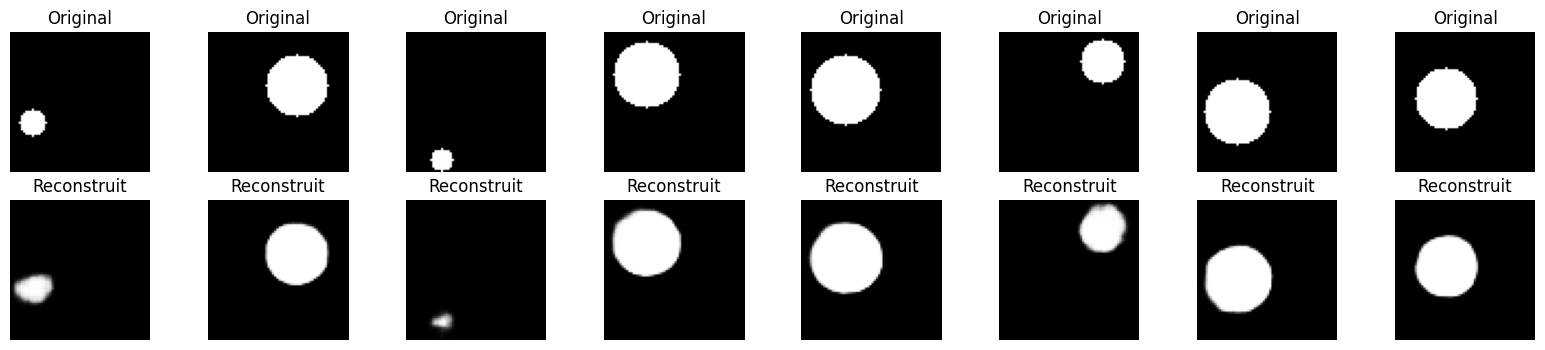

In [11]:
decoded_imgs_conv = autoencoder_conv.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Expérimentations

1. Tester les deux modèles sur des images d'entrées imparfaites (avec les imperfections de votre choix : parties cachées, bruits, ...). Interpréter les résultats.
2. Améliorer un des modèles ci-dessus de votre choix et montrer le résultat (sans modifier la taille de l'espace latent).
3. Selon les expériences menées dans ce notebook, votre avis et vos conaissances, est-il nécessaire d'augmenter la taille de l'espace latent pour avoir un réseau à faire ce travail. **Argumenter** votre réponse.

# **Reponse question n°1**
On a choisi le masquage partiel comme perturbation et on a pu interpreté que :

L'autoencodeur dense pourrait complètement déformer l'image.

L'autoencodeur convolutionnel devrait mieux reconstruire l'image en utilisant les informations des pixels voisins.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


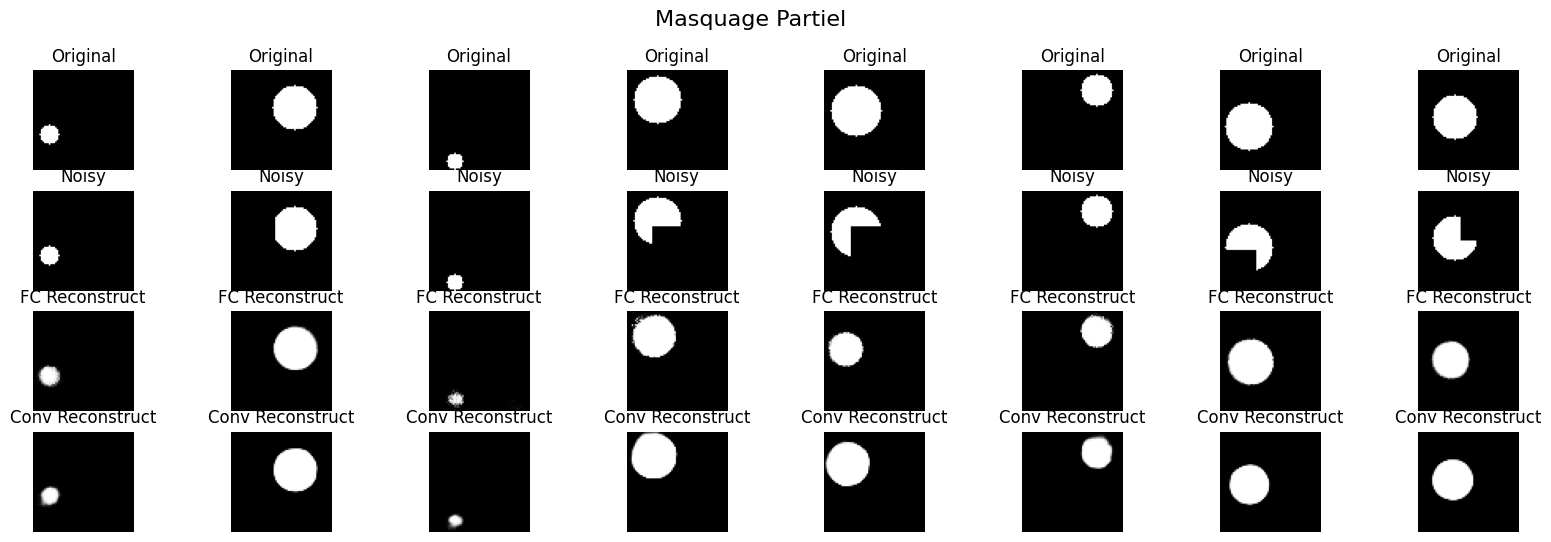

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model


# Charger les modèles entraînés (Assurez-vous d'avoir sauvegardé les modèles avant)
autoencoder_fc = load_model('autoencoder_fc.keras')  # Remplacez par le chemin de votre modèle
autoencoder_conv = load_model('autoencoder_conv.keras')  # Remplacez par le chemin de votre modèle

def mask_part_of_image(image, mask_size=20):
    """Ajoute un rectangle noir pour masquer une partie de l'image."""
    masked_image = image.copy()
    x, y = np.random.randint(0, image.shape[0] - mask_size, size=2)
    masked_image[x:x+mask_size, y:y+mask_size, 0] = 0
    return masked_image

# Sélectionner des images de test
n = 8
original_images = test_data[:n]
masked_images = [mask_part_of_image(img) for img in original_images]

# Appliquer les autoencodeurs
decoded_fc_masked = autoencoder_fc.predict(np.array(masked_images))

decoded_conv_masked = autoencoder_conv.predict(np.array(masked_images))

# Affichage des résultats
def plot_results(original, noisy, decoded_fc, decoded_conv, title):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(noisy[i].squeeze(), cmap='gray')
        plt.title('Noisy')
        plt.axis('off')

        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(decoded_fc[i].squeeze(), cmap='gray')
        plt.title('FC Reconstruct')
        plt.axis('off')

        ax = plt.subplot(4, n, i + 1 + 3*n)
        plt.imshow(decoded_conv[i].squeeze(), cmap='gray')
        plt.title('Conv Reconstruct')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

plot_results(original_images, masked_images, decoded_fc_masked, decoded_conv_masked, "Masquage Partiel")

# **Reponse question n°2**
On a choisi d'ameliorer autoencodeur convolutionel avec l'ajout de Dropout et BatchNormalization :

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │          49,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16384)               │          65,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,444 (740.02 KB)

 Trainable params: 189,316 (739.52 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 0.4461 - val_loss: 0.1658
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0789 - val_loss: 0.0861
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0356 - val_loss: 0.0491
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0294 - val_loss: 0.1005
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0241 - val_loss: 0.0281
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0221 - val_loss: 0.0280
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0223 - val_loss: 0.0337
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0209 - val_loss: 0.0154
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0249 - val_loss: 0.0817
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0185 - val_loss: 0.0237
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0174 - val_loss: 0.0195
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.

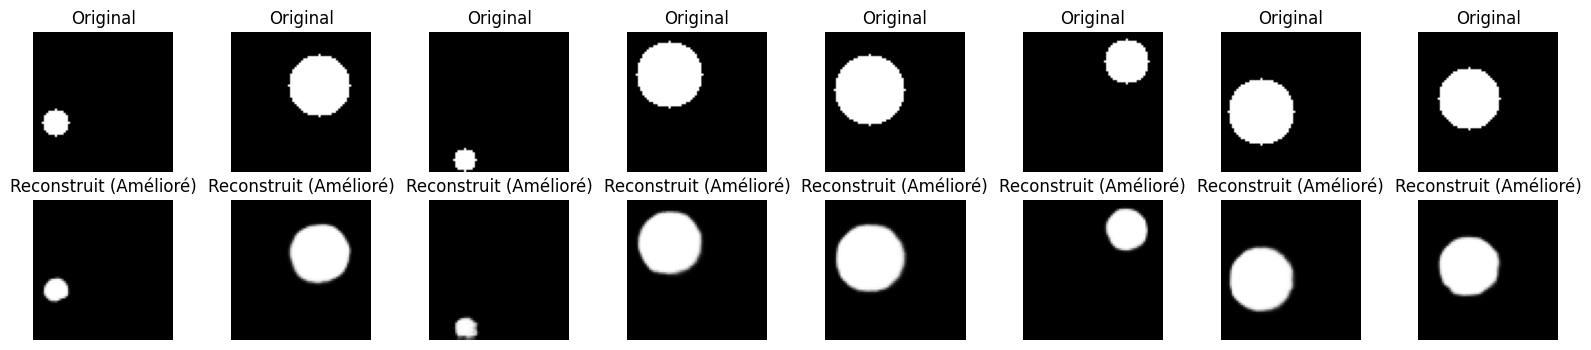

In [20]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(64, 64, 1))

# Encodeur
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Flatten()(x)
latent = layers.Dense(3, name='latent_space')(x)

# Décodeur
x = layers.Dense(16*16*64, activation='relu')(latent)
x = layers.Reshape((16,16,64))(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)  # Ajout de BatchNormalization
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Dropout(0.2)(x)  # Ajout de Dropout pour régularisation
decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

# Création du modèle
autoencoder_conv_improved = models.Model(input_img, decoded)

autoencoder_conv_improved.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_conv_improved.summary()

# Entraînement du modèle amélioré
history_conv_improved = autoencoder_conv_improved.fit(train_data, train_data,
                                                      epochs=20,
                                                      batch_size=128,
                                                      shuffle=True,
                                                      validation_data=(test_data, test_data))

# Visualisation des reconstructions améliorées
decoded_imgs_conv_improved = autoencoder_conv_improved.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv_improved[i].squeeze(), cmap='gray')
    plt.title('Reconstruit (Amélioré)')
    plt.axis('off')
plt.show()


#**Reponse question n°3**
Non, il n'est pas nécessaire d'augmenter la taille de l'espace latent pour ce travail précis, car l'espace latent de dimension 3 est suffisant pour un dataset de cercles relativement simple. Il est possible que l'augmentation de la taille de l'espace latent n'apporte pas de bénéfices significatifs en termes de qualité de reconstruction.

Cependant, cela dépend de la complexité des données. Si les images contiennent plus d'informations ou deviennent plus complexes, un espace latent plus grand pourrait être utile. Mais dans ce cas, avec des cercles simples, l'augmentation de la taille de l'espace latent pourrait entraîner un sur-apprentissage sans améliorer la qualité de la reconstruction.